In [1]:
### import utils
import warnings, utils

warnings.filterwarnings('ignore')
utils.set_css_style('style.css')

# Logistic Regression with Scikit-Learn

## The dataset

The dataset we'll be using contain the results of a virtual driving simulation of vehicles with an AD system. Based on the results of these simulations, we would like to predict for a new vehicle, whether the distance to the vehicle in front is respected and whether the safety distance is kept at all times, namely 2 seconds.

This variable is therefore binary (Did the vehicle keep the safety distance? Yes or no). We call it a warning.

The explanatory variables are called metadata. These are variables entered in the simulation scenario.

In [2]:
# Import Package
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

Reading the data in csv using `pandas`

In [3]:
metadata = pd.read_csv('Data/metadata.csv')
warnings = pd.read_csv('Data/warnings.csv')
print('metadata dataset size', str(metadata.shape))
print('warnings dataset size', str(warnings.shape))

metadata dataset size (19992, 13)
warnings dataset size (19990, 4)


In [4]:
metadata.head()

,scenario_id,AccelDur_s,LaneWidth_m,PVSpeed_kmh,PVPosit_m,PVAccel_ms2,PVDecel_ms2,PVCar,PVBus,PVMoto,Slope-6,Slope0,Slop6
0,5bc4920704c87d00012789f3,1.4,3.5,82.3,584.0,2.0,2.2,1,0,0,0,1,0
1,5bc4920704c87d00012789f4,1.9,3.5,97.3,563.0,1.5,2.8,1,0,0,0,1,0
2,5bc4920704c87d00012789f5,2.6,3.5,82.0,565.0,2.2,2.1,1,0,0,0,1,0
3,5bc4920704c87d00012789f6,1.8,3.5,83.3,687.0,2.2,1.2,1,0,0,0,1,0
4,5bc4920704c87d00012789f7,2.6,3.5,102.7,562.0,1.4,2.5,1,0,0,0,1,0


In [5]:
warnings.head()

,scenario_id,longitudinal_deceleration,safety_distance_m,safety_distance_s
0,5bc4920704c87d00012789f3,1.0,0.0,0.0
1,5bc4920704c87d00012789f4,0.0,1.0,1.0
2,5bc4920704c87d00012789f5,1.0,0.0,0.0
3,5bc4920704c87d00012789f6,1.0,0.0,0.0
4,5bc4920704c87d00012789f7,0.0,1.0,1.0


From `warnings` dataframe, we will only keep "safety_distance_s".

In [6]:
warnings = warnings[["scenario_id","safety_distance_s"]]

Let's join the dataframes together using the common key `scenario_id`

In [7]:
df = metadata.merge(warnings, left_on='scenario_id', right_on='scenario_id')
df = df.set_index('scenario_id')

In [8]:
#verification merge
df.head()

,AccelDur_s,LaneWidth_m,PVSpeed_kmh,PVPosit_m,PVAccel_ms2,PVDecel_ms2,PVCar,PVBus,PVMoto,Slope-6,Slope0,Slop6,safety_distance_s
scenario_id,,,,,,,,,,,,,
5bc4920704c87d00012789f3,1.4,3.5,82.3,584.0,2.0,2.2,1,0,0,0,1,0,0.0
5bc4920704c87d00012789f4,1.9,3.5,97.3,563.0,1.5,2.8,1,0,0,0,1,0,1.0
5bc4920704c87d00012789f5,2.6,3.5,82.0,565.0,2.2,2.1,1,0,0,0,1,0,0.0
5bc4920704c87d00012789f6,1.8,3.5,83.3,687.0,2.2,1.2,1,0,0,0,1,0,0.0
5bc4920704c87d00012789f7,2.6,3.5,102.7,562.0,1.4,2.5,1,0,0,0,1,0,1.0


In [9]:
df.shape

(19990, 13)

The **describe()** method is used for calculating some statistical data like percentile, mean and std of the numerical values of the Series or DataFrame. It analyzes both numeric and object series and also the DataFrame column sets of mixed data types.

In [10]:
df.describe()

,AccelDur_s,LaneWidth_m,PVSpeed_kmh,PVPosit_m,PVAccel_ms2,PVDecel_ms2,PVCar,PVBus,PVMoto,Slope-6,Slope0,Slop6,safety_distance_s
count,19990.000000,19990.000000,19990.000000,19990.000000,19990.000000,19990.000000,19990.000000,19990.000000,19990.000000,19990.000000,19990.000000,19990.000000,19990.000000
mean,2.523307,3.199970,85.232131,610.019210,1.995908,1.498624,0.333317,0.333317,0.333367,0.250025,0.249975,0.249975,0.469485
std,1.448339,0.300008,14.469862,56.911916,0.578122,0.868606,0.471410,0.471410,0.471428,0.433038,0.433009,0.433009,0.499080
min,0.000000,2.900000,60.000000,508.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.300000,2.900000,72.700000,561.000000,1.500000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.500000,2.900000,85.400000,610.000000,2.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.800000,3.500000,97.700000,659.000000,2.500000,2.300000,1.000000,1.000000,1.000000,0.750000,0.000000,0.000000,1.000000
max,5.000000,3.500000,110.000000,712.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Data preparation: splitting data into training and test sets

We will start by preparing the data:
    1. Creation of X and y
    2. Splitting the data into training and test sets

In [11]:
# X: explanatory variables / y: variable to predict
X = df.drop('safety_distance_s', axis=1)
y = df[["safety_distance_s"]]

In [12]:
#Création des sets d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Model training

Let's define our LogesticRegression, and fit it using the training set.

The Logestic Regression model on `scikit-learn` has a number of arguments, let's list some of them:

* **penalty**: {‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’: Used to specify the norm used in the regularization penalization.
* **C**: float, default=1.0: Inverse of regularization strength; must be a positive float. Smaller values specify stronger regularization.
* **l1_ratio**: float, default=None:  The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'.
* **fit_intercept**: bool, default=True: Specifies if a constant (a.k.a. bias or intercept $\theta_0$) should be added to the decision function.
* **solver**: {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’: Optimization algorithm to use in the optimization problem.
* **random_state**: int, RandomState instance, default=None: The seed of the pseudo random number generator to use when shuffling the data. 

In [13]:
## training the model
## Let tune the 'penalty' and 'C' hyperparameters
param_grid = {'penalty': ['l1', 'l2', 'none'],
              'C': [0.001, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5, 1, 10]}

logR = LogisticRegression(random_state=42, fit_intercept=True)
search = GridSearchCV(logR, param_grid, scoring='accuracy', cv=5)
search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.2,
                               0.3, 0.5, 1, 10],
                         'penalty': ['l1', 'l2', 'none']},
             scoring='accuracy')

The attribute "coef_" allows us to list the coefficients $\theta_1$, $\theta_2$, ... $\theta_{12}$ of our 12 features.

In [14]:
logR = search.best_estimator_
print(logR)

LogisticRegression(C=0.03, random_state=42)


In [15]:
logR.coef_

array([[ 0.07958489,  1.42889731,  0.03382876, -0.01535532, -1.21568528,
         1.22335507,  0.07697802,  1.40923986,  0.03573427, -0.44681898,
        -0.47070834,  0.17397264]])

We can also get our intercept $\theta_0$ with the attribute "intercept_".

In [16]:
logR.intercept_

array([1.75571492])

## Model predictions

In [17]:
# predicting over training & testing datasets
y_train_pred = logR.predict(X_train)
y_test_pred = logR.predict(X_test)

Printing the first 10 predictions:

In [18]:
y_test_pred[:10]

array([0., 1., 0., 1., 1., 0., 1., 0., 0., 1.])

##  Model evaluation 

### Accuracy

There are other ways of measuring model performance (precision, recall, F1 Score, ROC Curve, etc). The accuracy is very simple to obtain. To get the mean accuracy on the given training dataset, we can use the method `score`:

In [19]:
logR.score(X_train, y_train)

0.7712427642392625

To get the mean accuracy on the given test dataset, we can also use the method `score`:

In [20]:
logR.score(X_test, y_test)

0.7913956978489245

### Confusion Matrix

In [21]:
metrics.confusion_matrix(y_test, y_test_pred)

array([[2625,  585],
       [ 666, 2121]])

`scikit-learn` also offers a nice function to plot the confusion matrix.

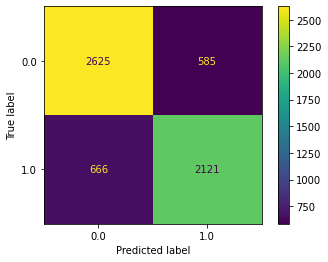

In [22]:
metrics.plot_confusion_matrix(logR, X_test, y_test)

### Recall

The recall of each class:

In [23]:
metrics.recall_score(y_test, y_test_pred, average=None)

array([0.81775701, 0.76103337])

### Precision

The precision of each class:

In [24]:
metrics.precision_score(y_test, y_test_pred, average=None)

array([0.7976299 , 0.78381375])

### F1score

The f1score of each class:

In [25]:
metrics.f1_score(y_test, y_test_pred, average=None)

array([0.80756807, 0.7722556 ])

### Receiver Operating Characteristic - AUC

In able to plot ROC or evaluate AUC, we need the probability outputs of our model instead of the final prediction.

We call the `predict_proba` method rather than `predict` in order to obtain a list of probabilities which represent the likelihood that a sample falls under a given category. 

In [26]:
probs = logR.predict_proba(X_test)
malignant_probs = probs[:,1]

# calculating roc arguments
fpr, tpr, thresholds = metrics.roc_curve(y_test, malignant_probs)
# calculating auc
roc_auc = metrics.auc(fpr, tpr)

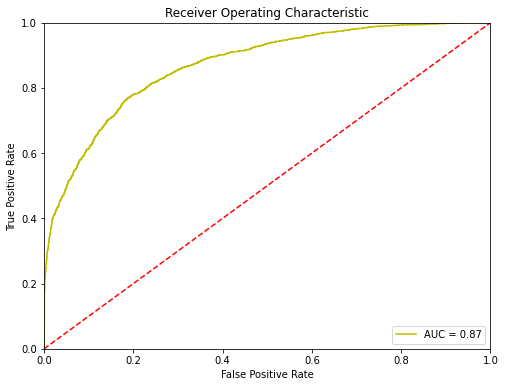

In [27]:
plt.figure(figsize=[8,6])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'y', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()